# Text Classification with Conv1D, RNN, LSTM, GRU, BiLSTM

## Intsallation

In [2]:
# Install needed libraries commands 
# !pip install tensorflow
# !pip install matplotlib
# !pip install numpy
# !pip install pandas
# !pip install wordcloud

## Part 1: Dataset Exploration

IMDB dataset having 50K movie reviews for natural language processing or Text analytics.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training and 25,000 for testing. So, predict the number of positive and negative reviews using either classification or deep learning algorithms.
For more dataset information, please go through the following link,
http://ai.stanford.edu/~amaas/data/sentiment/

### 1.1 Load the Data

In [3]:
import pandas as pd

# Load the dataset
data = pd.read_csv("IMDB Dataset.csv")

# Display the first few rows of the dataset
data.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Explanation:
- review: This column contains the actual movie reviews (text data).

- sentiment: This column contains the sentiment of the review ('negative' or 'Postive').

### 1.2 Dataset Overview

In [4]:
# Check the shape of the dataset
print("Dataset shape:", data.shape)

# Check for any missing values
print("Missing values in each column:")
print(data.isnull().sum())

# Check the data types of the columns
print("Data types:")
print(data.dtypes)


Dataset shape: (50000, 2)
Missing values in each column:
review       0
sentiment    0
dtype: int64
Data types:
review       object
sentiment    object
dtype: object


### 1.3 Check Data Distribution

In [5]:
# Check the distribution of sentiment labels
data['sentiment'].value_counts()


sentiment
positive    25000
negative    25000
Name: count, dtype: int64

### 1.4 Review Length Distribution

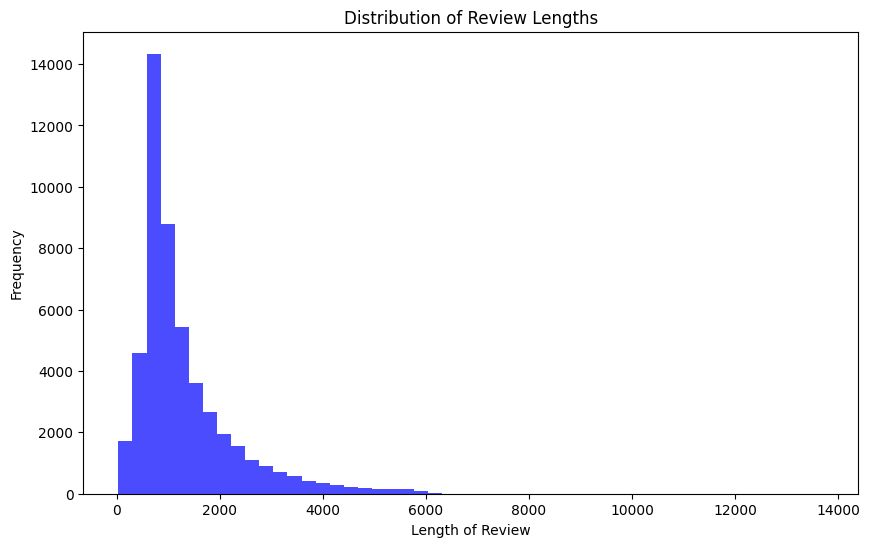

In [6]:
# Calculate the length of each review
data['review_length'] = data['review'].apply(len)

# Plot the distribution of review lengths
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(data['review_length'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Review Lengths')
plt.xlabel('Length of Review')
plt.ylabel('Frequency')
plt.show()


### 1.5. Sample Reviews

In [7]:
# Dislay some random postive and negative reviews
print("Positive Reviews:")
print(data[data['sentiment'] == 'positive'].sample(5)['review'].values)
print("\nNegative Reviews:")
print(data[data['sentiment'] == 'negative'].sample(5)['review'].values)



Positive Reviews:
["I was one of about 200 people that was lucky enough to see an early sneak of this film.<br /><br />Stardust follows Tristan a young man on a quest to find a fallen star and bring it back to the woman he loves in order to prove his love for her. The only catch is that the star has fallen on the other side of the wall, a doorway between England and a magical kingdom known as Stormhold.<br /><br />This film was just a joy to watch, it has something in it for everyone, all of the action scenes are played out beautifully and the comedy is spread out through the film making it funny without being corny. If I had to compare the likes to another film it would probably have to be The Princess Bride, a classic.<br /><br />All the performances are outstanding, the beautiful Claire Danes makes you love her in her portrayal of Yvaine the trusting naive star and under rated Michelle Pfeiffer delivers a stellar over the top performance as Larnia...but the performance to talk about

### 1.6 Word Cloud of Reviews

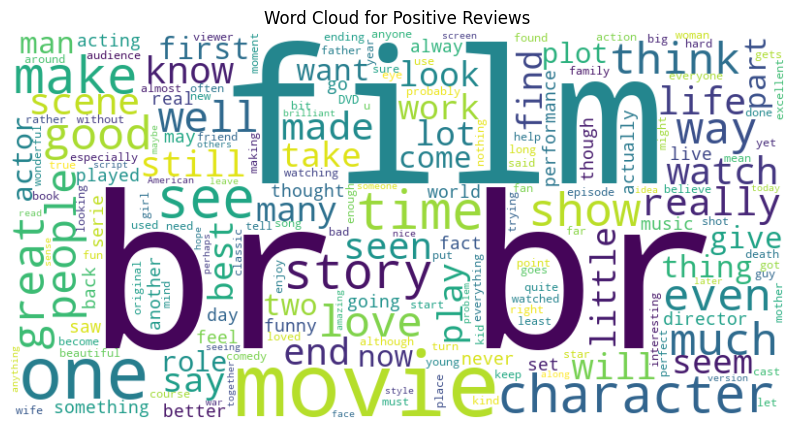

In [8]:
from wordcloud import WordCloud
# Generate a word cloud for positive reviews
positive_reviews = ' '.join(data[data['sentiment'] == 'positive']['review'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

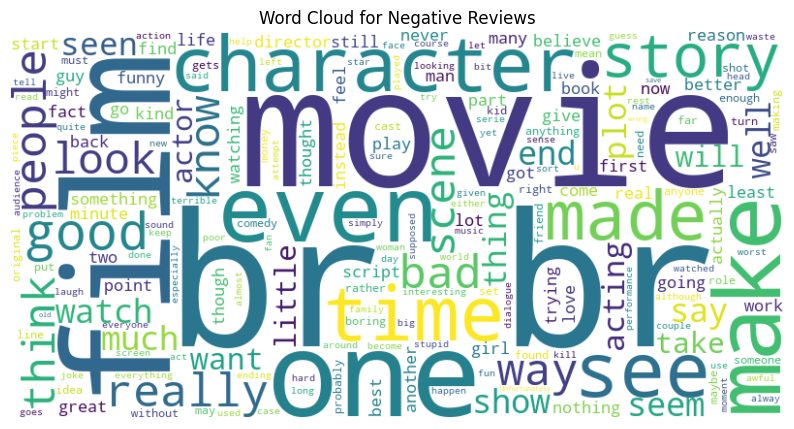

In [9]:
# Generate a word cloud for negative reviews
negative_reviews = ' '.join(data[data['sentiment'] == 'negative']['review'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()


## Text Cleaning

In [ ]:
import re

def clean_text(text):
    """
    Cleans the input text by:
    - Lowercasing
    - Removing HTML tags
    - Removing non-alphabet characters
    - Removing extra spaces
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove non-alphabetic characters
    text = re.sub(r"[^a-zA-Z]", " ", text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply cleaning to the reviews
data['cleaned_review'] = data['review'].apply(clean_text)

# Display a few cleaned examples
data[['review', 'cleaned_review']].head()


,review,cleaned_review
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,basically there s a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei s love in the time of money is a...


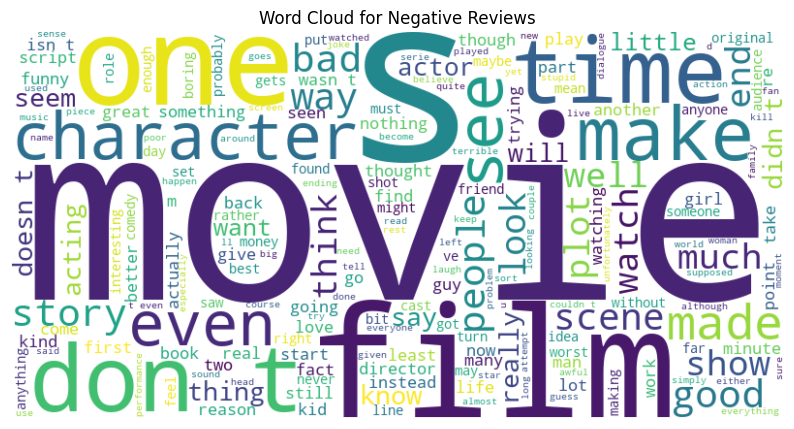

In [11]:
# Generate a word cloud for negative reviews
negative_reviews = ' '.join(data[data['sentiment'] == 'negative']['cleaned_review'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

## Data Preprocessing 

- Tokenization: Convert text into sequences of integers (each word → unique ID)
- Padding: Ensure all sequences have the same length (important for batch training)
- Splitting: Train/Test split

In [12]:
# Importing necessary libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# ----------------------------------------
# Step 1: Define Hyperparameters
# ----------------------------------------

vocab_size = 10000  # Limit the vocabulary to the top 10,000 most frequent words
maxlen = 200        # Set a maximum review length (in number of tokens) after padding/truncating

# ----------------------------------------
# Step 2: Initialize and Fit the Tokenizer
# ----------------------------------------

# Create a Tokenizer instance
# num_words specifies the maximum number of unique words to keep, based on word frequency
# oov_token specifies a token ("<OOV>") for words that are out of vocabulary
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")

# Fit the Tokenizer on the cleaned review texts
# This builds the word index (mapping words to integers)
tokenizer.fit_on_texts(data['cleaned_review'])

# ----------------------------------------
# Step 3: Convert Text to Integer Sequences
# ----------------------------------------

# Transform each cleaned review into a sequence of integers
# Each integer corresponds to the index of the word in the tokenizer's word index
sequences = tokenizer.texts_to_sequences(data['cleaned_review'])

# ----------------------------------------
# Step 4: Apply Padding to Sequences
# ----------------------------------------

# Pad or truncate the sequences to ensure uniform length
# maxlen specifies the fixed length for all sequences
# padding='post' appends zeros at the end if the sequence is shorter than maxlen
# truncating='post' cuts off extra tokens at the end if the sequence is longer than maxlen
padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

# ----------------------------------------
# Step 5: Prepare the Labels
# ----------------------------------------

# Extract the sentiment labels as a NumPy array
# Labels are binary (0 for negative, 1 for positive)
labels = data['sentiment'].values

# ----------------------------------------
# Step 6: Train/Test Split
# ----------------------------------------

# Split the data into training and testing sets
# 80% of the data is used for training and 20% for testing
# random_state ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# ----------------------------------------
# Step 7: Summary of the Preprocessing
# ----------------------------------------

# Display the number of samples in training and testing datasets
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 40000
Testing samples: 10000


In [13]:
# If they are strings in arrays
import numpy as np

y_train = np.where(y_train == 'positive', 1, 0).astype('float32')
y_test = np.where(y_test == 'positive', 1, 0).astype('float32')



## Modelling

- We'll experiment with several types of neural network architectures: Conv1D, Simple RNN, LSTM, GRU, and Bidirectional LSTM (BiLSTM).

- For each model:

    - We'll use an Embedding layer to transform word indices into dense vectors.

    - We'll use Dropout for regularization to avoid overfitting.

    - We'll use EarlyStopping during training to stop when validation performance stops improving.

    - We'll Save the trained models for future use.



### Conv1D

- Applies convolution filters over sequences of words.

- Captures local patterns like phrases (e.g., "very good", "not bad").

- Useful for detecting n-grams patterns.

- Faster than RNN-based models.

In [14]:
# Import necessary modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.saving import save_model

# Define EarlyStopping and ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

checkpoint_conv1d = ModelCheckpoint('conv1d_model.keras', save_best_only=True)

# Build the Conv1D model
conv1d_model = Sequential([
    # Embedding layer to learn dense vector representations of words
    Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen),

    # Convolution layer with 128 filters and kernel size 5
    Conv1D(filters=128, kernel_size=5, activation='relu'),

    # GlobalMaxPooling to reduce each feature map to a single number
    GlobalMaxPooling1D(),

    # Dropout layer to prevent overfitting
    Dropout(0.5),

    # Fully connected (Dense) output layer with sigmoid activation for binary classification
    Dense(1, activation='sigmoid')
])

# Compile the model
conv1d_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history_conv1d = conv1d_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint_conv1d]
)



C:\Users\aliae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 52ms/step - accuracy: 0.6584 - loss: 0.5856 - val_accuracy: 0.8490 - val_loss: 0.3475
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.8745 - loss: 0.3014 - val_accuracy: 0.8619 - val_loss: 0.3206
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.9261 - loss: 0.2035 - val_accuracy: 0.8650 - val_loss: 0.3324
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.9548 - loss: 0.1330 - val_accuracy: 0.8596 - val_loss: 0.3778
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.9736 - loss: 0.0844 - val_accuracy: 0.8545 - val_loss: 0.4350


### Model 2: Simple RNN
- Processes the input sequentially (word-by-word).

- Remembers previous context using internal state.

- Good for short-term patterns.

- Can suffer from vanishing gradient problems on long sequences.

In [15]:
# Import necessary modules
from tensorflow.keras.layers import SimpleRNN

checkpoint_rnn = ModelCheckpoint('simple_rnn_model.keras', save_best_only=True)

# Build the Simple RNN model
rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen),
    SimpleRNN(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history_rnn = rnn_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint_rnn]
)


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 58ms/step - accuracy: 0.5016 - loss: 0.7011 - val_accuracy: 0.5006 - val_loss: 0.6954
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - accuracy: 0.5088 - loss: 0.7097 - val_accuracy: 0.5146 - val_loss: 0.6933
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.5118 - loss: 0.6947 - val_accuracy: 0.4970 - val_loss: 0.6937
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.5206 - loss: 0.6921 - val_accuracy: 0.5238 - val_loss: 0.6918
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 57ms/step - accuracy: 0.5374 - loss: 0.6835 - val_accuracy: 0.5151 - val_loss: 0.6934
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.5468 - loss: 0.6744 - val_accuracy: 0.5164 - val_loss: 0.6920
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.5680 - loss: 0.6613 - val_accuracy: 0.5201 - val_loss: 0.6950


### Model 3: Long Short-Term Memory (LSTM)

- A type of RNN designed to remember information for longer periods.

- Uses gates to control what information is remembered or forgotten.

- Solves the vanishing gradient problem.

- Excellent for capturing long-range dependencies in text.

In [16]:
# Import necessary modules
from tensorflow.keras.layers import LSTM

checkpoint_lstm = ModelCheckpoint('lstm_model.keras', save_best_only=True)

# Build the LSTM model
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint_lstm]
)


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 76s 149ms/step - accuracy: 0.5176 - loss: 0.6913 - val_accuracy: 0.5707 - val_loss: 0.6643
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 72s 144ms/step - accuracy: 0.6037 - loss: 0.6580 - val_accuracy: 0.6037 - val_loss: 0.6531
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 67s 135ms/step - accuracy: 0.6810 - loss: 0.6150 - val_accuracy: 0.7664 - val_loss: 0.5299
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 67s 134ms/step - accuracy: 0.7751 - loss: 0.5206 - val_accuracy: 0.7111 - val_loss: 0.6147
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 68s 135ms/step - accuracy: 0.7823 - loss: 0.5034 - val_accuracy: 0.7936 - val_loss: 0.4846
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 68s 135ms/step - accuracy: 0.7756 - loss: 0.5012 - val_accuracy: 0.8027 - val_loss: 0.4711
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 68s 136ms/step - accuracy: 0.7469 - loss: 0.5431 - val_accuracy: 0.8436 - val_loss: 0.3749
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 58s 115ms/step - accuracy: 0.8835 - loss: 0

### Model 4: Gated Recurrent Unit (GRU)

- A simpler and faster alternative to LSTM.

- Uses fewer gates than LSTM but performs similarly.

- Good choice when you want faster training but still need sequence memory.

In [17]:
# Import necessary modules
from tensorflow.keras.layers import GRU

checkpoint_gru = ModelCheckpoint('gru_model.keras', save_best_only=True)

# Build the GRU model
gru_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen),
    GRU(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history_gru = gru_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint_gru]
)


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 73ms/step - accuracy: 0.5120 - loss: 0.6925 - val_accuracy: 0.6357 - val_loss: 1.0315
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 74ms/step - accuracy: 0.5875 - loss: 0.6784 - val_accuracy: 0.8487 - val_loss: 0.3762
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step - accuracy: 0.8807 - loss: 0.3029 - val_accuracy: 0.8780 - val_loss: 0.2962
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 77ms/step - accuracy: 0.9344 - loss: 0.1887 - val_accuracy: 0.8801 - val_loss: 0.3085
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 74ms/step - accuracy: 0.9625 - loss: 0.1195 - val_accuracy: 0.8749 - val_loss: 0.3526
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - accuracy: 0.9757 - loss: 0.0842 - val_accuracy: 0.8565 - val_loss: 0.4491


### Model 5: Bidirectional LSTM (BiLSTM)

- Reads the sequence both forward and backward.

- Captures future and past context at every step.

- Very powerful for text understanding tasks.

In [ ]:
# Import necessary modules
from tensorflow.keras.layers import Bidirectional

checkpoint_bilstm = ModelCheckpoint('bilstm_model.keras', save_best_only=True)

# Build the BiLSTM model
bilstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
bilstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history_bilstm = bilstm_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint_bilstm]
)


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 97ms/step - accuracy: 0.6908 - loss: 0.5592 - val_accuracy: 0.8414 - val_loss: 0.3706
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 48s 97ms/step - accuracy: 0.8892 - loss: 0.2881 - val_accuracy: 0.8559 - val_loss: 0.3551
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 99ms/step - accuracy: 0.9160 - loss: 0.2284 - val_accuracy: 0.8674 - val_loss: 0.3486
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 101ms/step - accuracy: 0.9272 - loss: 0.1936 - val_accuracy: 0.8687 - val_loss: 0.3811
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 49s 97ms/step - accuracy: 0.9485 - loss: 0.1459 - val_accuracy: 0.8701 - val_loss: 0.4025
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - accuracy: 0.9648 - loss: 0.1033 - val_accuracy: 0.8593 - val_loss: 0.4500


## Model Evaluation, Comparison, and Loading Saved Models

After training, we must check how each model performs on unseen test data.

We evaluate using:

Accuracy: How many predictions were correct.

Loss: How wrong the model's predictions are.

We use model.evaluate(X_test, y_test).

In [19]:
# Import libraries
import matplotlib.pyplot as plt
from keras.models import load_model

# Evaluate LSTM model
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Model - Test Accuracy: {lstm_test_acc:.4f}, Test Loss: {lstm_test_loss:.4f}")

# Evaluate GRU model
gru_test_loss, gru_test_acc = gru_model.evaluate(X_test, y_test, verbose=0)
print(f"GRU Model - Test Accuracy: {gru_test_acc:.4f}, Test Loss: {gru_test_loss:.4f}")

# Evaluate Conv1D model
conv1d_test_loss, conv1d_test_acc = conv1d_model.evaluate(X_test, y_test, verbose=0)
print(f"Conv1D Model - Test Accuracy: {conv1d_test_acc:.4f}, Test Loss: {conv1d_test_loss:.4f}")

# Evaluate BiLSTM model
bilstm_test_loss, bilstm_test_acc = bilstm_model.evaluate(X_test, y_test, verbose=0)
print(f"BiLSTM Model - Test Accuracy: {bilstm_test_acc:.4f}, Test Loss: {bilstm_test_loss:.4f}")

# Evaluate Simple RNN model
simple_rnn_test_loss, simple_rnn_test_acc = rnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Simple RNN Model - Test Accuracy: {simple_rnn_test_acc:.4f}, Test Loss: {simple_rnn_test_loss:.4f}")


LSTM Model - Test Accuracy: 0.8547, Test Loss: 0.3594
GRU Model - Test Accuracy: 0.8748, Test Loss: 0.2950
Conv1D Model - Test Accuracy: 0.8639, Test Loss: 0.3131
BiLSTM Model - Test Accuracy: 0.8637, Test Loss: 0.3470
Simple RNN Model - Test Accuracy: 0.5151, Test Loss: 0.6922


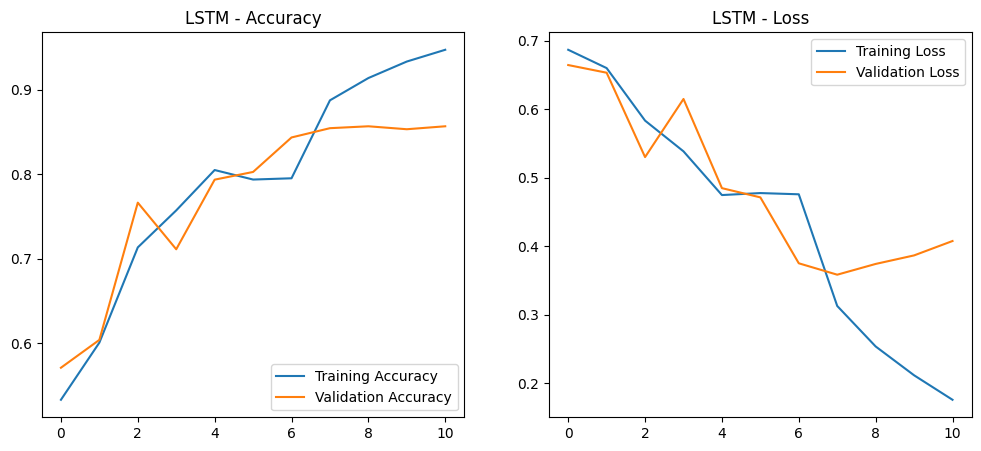

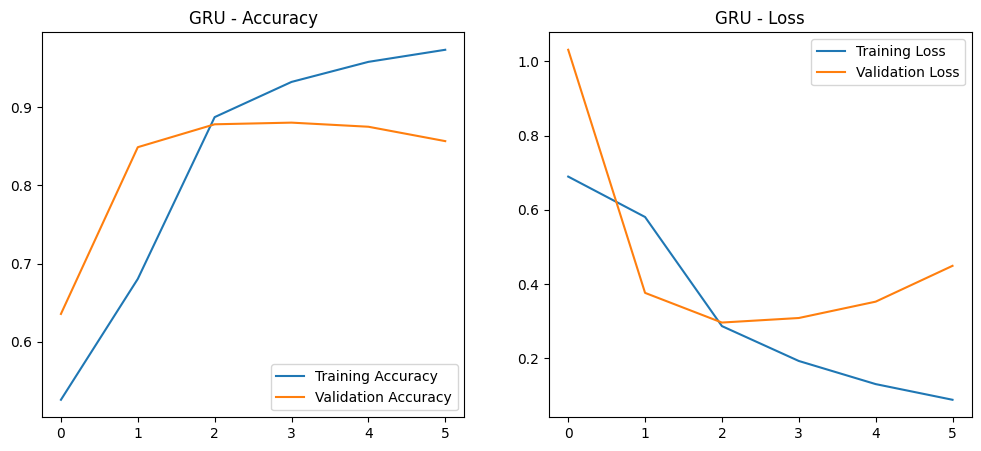

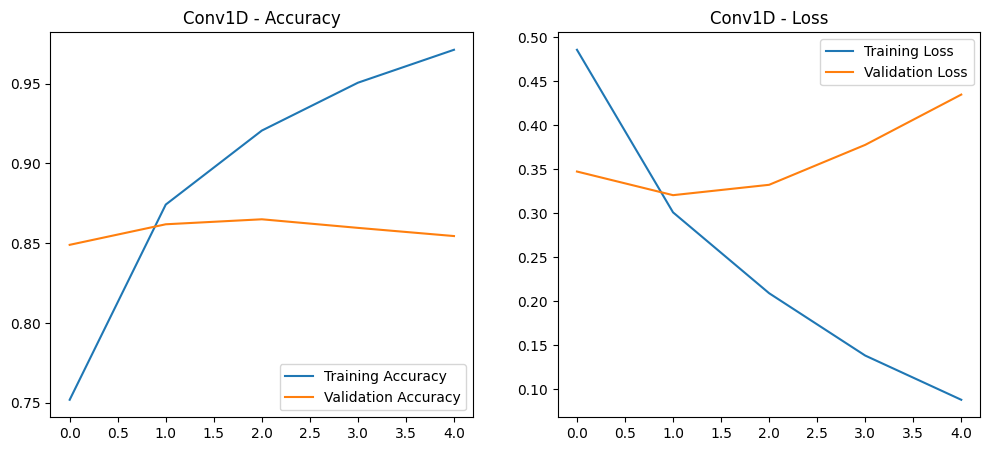

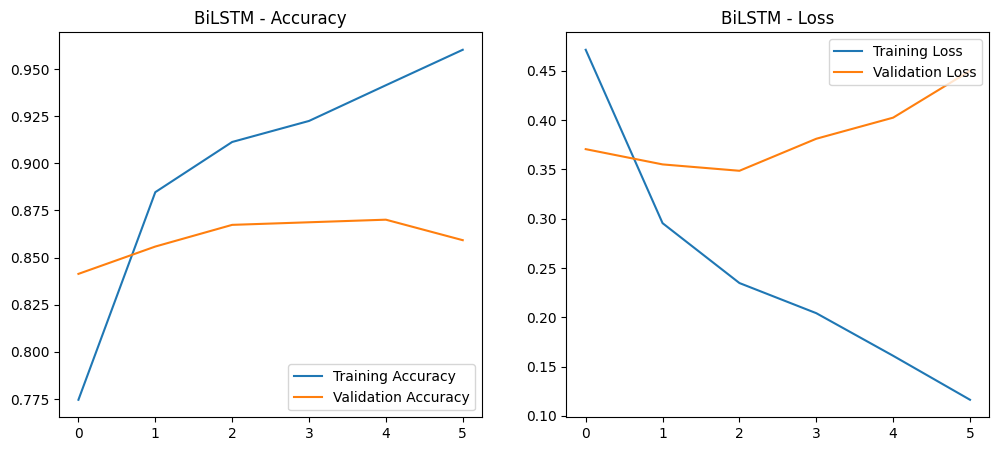

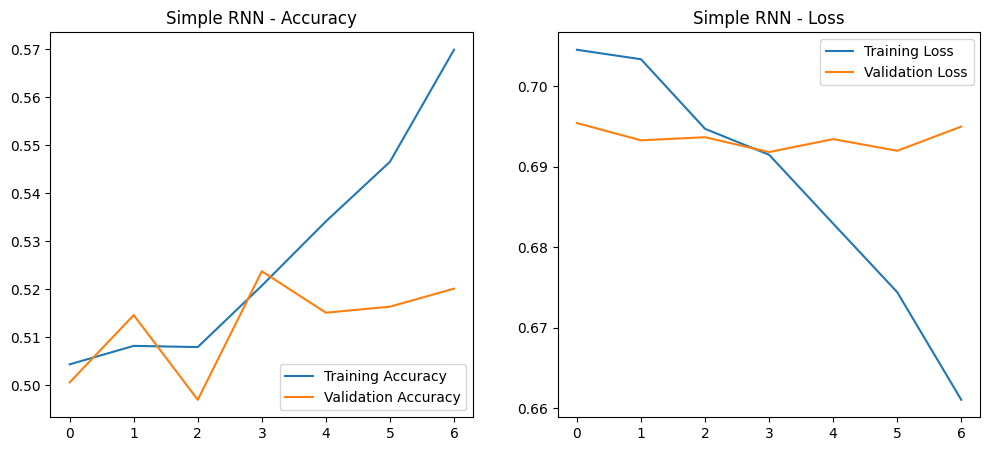

In [20]:
# Function to plot training history
def plot_learning_curves(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Loss')

    plt.show()

# Plot for each model
plot_learning_curves(history_lstm, "LSTM")
plot_learning_curves(history_gru, "GRU")
plot_learning_curves(history_conv1d, "Conv1D")
plot_learning_curves(history_bilstm, "BiLSTM")
plot_learning_curves(history_rnn, "Simple RNN")


####  Loading and Reusing Saved Models

In [21]:
# Load models from saved checkpoints
best_lstm_model = load_model('lstm_model.keras')
best_gru_model = load_model('gru_model.keras')
best_conv1d_model = load_model('conv1d_model.keras')

# Example: Evaluate loaded LSTM model
loss, acc = best_lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"Loaded Best LSTM Model - Test Accuracy: {acc:.4f}, Test Loss: {loss:.4f}")


Loaded Best LSTM Model - Test Accuracy: 0.8547, Test Loss: 0.3594
